In [2]:
import os
import pandas as pd
import functools
import time
from collections import namedtuple


import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import xticks

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from scipy.optimize import curve_fit

import invisible_cities.icaro.hst_functions as hsti
# Import JAH's improved hst functions for now, to allow for statistics boxes in histograms.
# Idea is that something like this will be imported in invisible_cities in the future.

import myhst_functions as hst

# Import alpha selection functions
#import AlphaSelectionFunctions as asf

In [3]:
plt.style.available
#plt.style.use('seaborn-white')
plt.style.use('seaborn-talk')

optStat = True

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Abrimos los ficheros con los datos (4576, 4495)

In [5]:
#### Leemos primero el fichero con los datos
inputFolder_4576 = "/Users/jjgomezcadenas/Projects/ICDEV/data/"
inputFilename_4576 = inputFolder_4576+"4576_positions.hdf5" 
datos_4576 = pd.read_hdf(inputFilename_4576)
#print(datos_4576)

inputFolder_4495 = "/Users/jjgomezcadenas/Projects/ICDEV/data/"
inputFilename_4495 = inputFolder_4495+"4495_positions.hdf5" 
datos_4495 = pd.read_hdf(inputFilename_4495)
#print(datos_4495)

In [6]:
datos_4576.time

AttributeError: 'DataFrame' object has no attribute 'time'

### Cálculo del tiempo transcurrido desde el primer evento hasta el último

In [7]:
#### Cálculo del tiempo transcurrido desde el primer evento hasta el último
tiempo_in_4576 = datos_4576.time[0]
tiempo_fin_4576 = datos_4576.time[len(datos_4576)-1]
tiempo_total_4576 = tiempo_fin_4576 - tiempo_in_4576
print('Tiempo total run 4576: ', tiempo_total_4576, 's')


#### lo mismo para el otro fichero
tiempo_in_4495 = datos_4495.time[0]
tiempo_fin_4495 = datos_4495.time[len(datos_4495)-1]
tiempo_total_4495 = tiempo_fin_4495 - tiempo_in_4495
print('Tiempo total run 4495: ', tiempo_total_4495, 's')

AttributeError: 'DataFrame' object has no attribute 'time'

### Unión

In [6]:
#### Unimos ahora los diferentes ficheros obtenidos
#### TAMAÑO DEL BLOB 21
for i in range(0, 10):
    locals()['data_4495_{0}'.format(i+1)] = pd.read_hdf('/home/ausonandres/ICARO/ElectronAnalysis/positionHITS/PosHITS_4495_{0}.hdf5'.format(i+1))
    locals()['data_4576_{0}'.format(i+1)] = pd.read_hdf('scripts_results/PosHITS_4576_{0}.hdf5'.format(i+1))

    
frames = [data_4495_1, data_4495_2, data_4495_3, data_4495_4, data_4495_5, data_4495_6, data_4495_7, data_4495_8, data_4495_9, data_4495_10]
frames2 = [data_4576_1, data_4576_2, data_4576_3, data_4576_4, data_4576_5, data_4576_6, data_4576_7, data_4576_8, data_4576_9, data_4576_10]
data_4495 = pd.concat(frames, ignore_index=True)
data_4576 = pd.concat(frames2, ignore_index=True)
#print(data_4495)
print(data_4576)

             Xavg        Yavg        Zavg  centre_dist       eblob1  \
0      -36.514403   55.497008  534.275000     6.288641   541.849722   
1      -74.512794 -104.677762  531.421429     7.992541   211.572613   
2      -74.512794 -104.677762  531.421429     8.821936    77.578118   
3      -74.512794 -104.677762  531.421429    10.703731   639.686453   
4      105.491118  148.900964  175.434524     7.655140   469.824145   
5     -152.235832   91.174763  292.586364     7.063539   476.164313   
6        7.075736  177.839466  106.275000     9.214514   366.219284   
7      127.416211    7.085253  496.700000     8.412385   365.957012   
8      123.105250   81.457164  348.075000     2.977168   388.306092   
9      110.848078   69.383851  373.175000     7.631967   308.434246   
10     110.848078   69.383851  373.175000     5.520562   304.410739   
11      28.408829 -159.399632   74.870739     4.630501   242.894611   
12      28.408829 -159.399632   74.870739     6.385732   187.188249   
13    

### Z y E de los eventos

#### 4576

In [51]:
#### queremos representar en el histograma la energia (o Z) del evento
data_4576_2 = data_4576
Z_evt_4576 = np.array([])
maxZ_evt_4576 = np.array([])
X_evt_4576 = np.array([])
Y_evt_4576 = np.array([])
E_evt_4576 = np.array([])
m = 0
for m in range(0, len(data_4576_2)-1):
    if data_4576_2.Zavg[m] != data_4576_2.Zavg[m+1]:
        Z_evt_4576 = np.append(Z_evt_4576, data_4576_2.Zavg[m], axis=None)
        maxZ_evt_4576 = np.append(maxZ_evt_4576, data_4576_2.maxZ[m], axis=None)
        X_evt_4576 = np.append(X_evt_4576, data_4576_2.Xavg[m], axis=None)
        Y_evt_4576 = np.append(Y_evt_4576, data_4576_2.Yavg[m], axis=None)
        E_evt_4576 = np.append(E_evt_4576, data_4576_2.evt_energy[m], axis=None)
        
if data_4576_2.Zavg[len(data_4576_2)-1] != Z_evt_4576[len(Z_evt_4576)-1]:
    Z_evt_4576 = np.append(Z_evt_4576, data_4576_2.Zavg[len(data_4576_2)-1], axis=None)
    maxZ_evt_4576 = np.append(maxZ_evt_4576, data_4576_2.maxZ[len(data_4576_2)-1], axis=None)
    E_evt_4576 = np.append(E_evt_4576, data_4576_2.evt_energy[len(data_4576_2)-1], axis=None)
    X_evt_4576 = np.append(X_evt_4576, data_4576_2.Xavg[len(data_4576_2)-1], axis=None)
    Y_evt_4576 = np.append(Y_evt_4576, data_4576_2.Yavg[len(data_4576_2)-1], axis=None)
    
#print(Z_evt_4576)
print(E_evt_4576)


[  541.84972217  1467.27937829   703.40636471 ...,   530.53068836
   708.81356677   725.0423361 ]


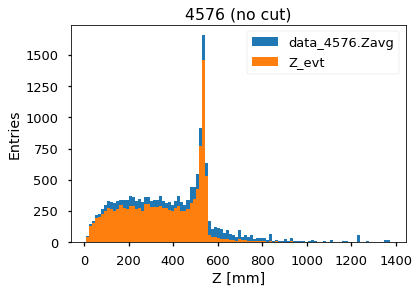

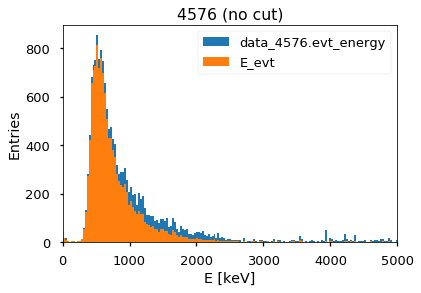

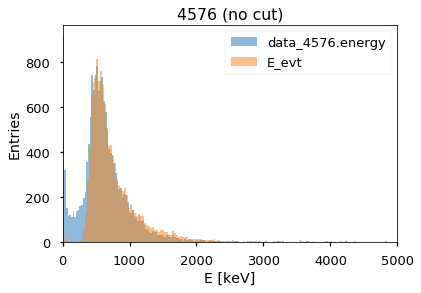

In [76]:
pyplot.hist(data_4576.Zavg, 100, alpha=1, label='data_4576.Zavg');
pyplot.hist(Z_evt_4576, 100, alpha=1, label='Z_evt');
pyplot.legend(loc='upper right')
plt.xlabel('Z [mm]')
plt.ylabel('Entries')
plt.title('4576 (no cut)')
pyplot.show()

plt.figure()
pyplot.hist(data_4576.evt_energy, 1000, alpha=1, label='data_4576.evt_energy');
pyplot.hist(E_evt_4576, 1000, alpha=1, label='E_evt');
plt.xlim(0, 5000)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Entries')
plt.title('4576 (no cut)')
pyplot.show()

plt.figure()
pyplot.hist(data_4576.energy, 1000, alpha=0.5, label='data_4576.energy');
pyplot.hist(E_evt_4576, 1000, alpha=0.5, label='E_evt');
plt.xlim(0, 5000)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Entries')
plt.title('4576 (no cut)')
pyplot.show()

#### 4495

In [49]:
data_4495_2 = data_4495
Z_evt_4495 = np.array([])
X_evt_4495 = np.array([])
Y_evt_4495 = np.array([])
E_evt_4495 = np.array([])
m = 0
for m in range(0, len(data_4495_2)-1):
    if data_4495_2.Zavg[m] != data_4495_2.Zavg[m+1]:
        Z_evt_4495 = np.append(Z_evt_4495, data_4495_2.Zavg[m], axis=None)
        X_evt_4495 = np.append(X_evt_4495, data_4495_2.Xavg[m], axis=None)
        Y_evt_4495 = np.append(Y_evt_4495, data_4495_2.Yavg[m], axis=None)
        E_evt_4495 = np.append(E_evt_4495, data_4495_2.evt_energy[m], axis=None)
        
if data_4495_2.Zavg[len(data_4495_2)-1] != Z_evt_4495[len(Z_evt_4495)-1]:
    Z_evt_4495 = np.append(Z_evt_4495, data_4495_2.Zavg[len(data_4495_2)-1], axis=None)
    X_evt_4495 = np.append(X_evt_4495, data_4495_2.Xavg[len(data_4495_2)-1], axis=None)
    Y_evt_4495 = np.append(Y_evt_4495, data_4495_2.Yavg[len(data_4495_2)-1], axis=None)
    E_evt_4495 = np.append(E_evt_4495, data_4495_2.evt_energy[len(data_4495_2)-1], axis=None)
#print(Z_evt_4495)
print(E_evt_4495)

[  460.12266939   568.3906482    443.08113766 ...,  1471.24131654
   968.45676328   648.8257262 ]


In [13]:
print(len(E_evt_4576))
print(len(E_evt_4576[E_evt_4576>600]))

12889
7441


### CORTES

In [29]:
##### HAGAMOS AHORA LOS DISTINTOS CORTES PARA UNO DE LOS ARCHIVOS: 4475
num = 4576

### Fiducial
locals()['data_sel_{0}'.format(num)] = locals()['data_{0}'.format(num)][(locals()['data_{0}'.format(num)].minZ > 20) & (locals()['data_{0}'.format(num)].maxZ < 512)]
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].maxR < 178]
corteF_4576 = locals()['data_sel_{0}'.format(num)].event.nunique()
print('Pasan el corte Fiducial: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique(), '(', corteF_4576/locals()['data_{0}'.format(num)].event.nunique(), ')')

### Single Track
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].numb_of_tracks == 1]
corteST_4576 = locals()['data_sel_{0}'.format(num)].event.nunique()
print('Pasan el corte Fiducial + Single track: ', len(locals()['data_sel_{0}'.format(num)]), '/', locals()['data_{0}'.format(num)].event.nunique(), '(', corteST_4576/locals()['data_{0}'.format(num)].event.nunique(), ')')

### Energy cut
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].energy>600]
corteE_4576 = locals()['data_sel_{0}'.format(num)].event.nunique()
print('Pasan el corte Fiducial + Single track + Energy: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique(), '(', corteE_4576/locals()['data_{0}'.format(num)].event.nunique(), ')')

### Blob cut
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][(locals()['data_sel_{0}'.format(num)].eblob1>300) & (locals()['data_sel_{0}'.format(num)].eblob2>300)]
corteB_4576 = locals()['data_sel_{0}'.format(num)].event.nunique()
print('Pasan el corte Fiducial + Single track + Energy + Blob cut: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique(), '(', corteB_4576/locals()['data_{0}'.format(num)].event.nunique(), ')')

#print(locals()['data_sel_{0}'.format(num)])

### Rate eventos
print('Rate (no cut): ', locals()['data_{0}'.format(num)].event.nunique()/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')
#print('Rate (no cut): ', len(locals()['E_evt_{0}'.format(num)])/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')

#print('Rate (inclusive): ', locals()['data_{0}'.format(num)][locals()['data_{0}'.format(num)].energy>600].event.nunique()/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')
print('Rate (inclusive): ', len(locals()['E_evt_{0}'.format(num)][locals()['E_evt_{0}'.format(num)]>600])/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')

locals()['rate_{0}'.format(num)] = len(locals()['data_sel_{0}'.format(num)])/(locals()['tiempo_total_{0}'.format(num)])
print('Rate (dbd cut): ', locals()['rate_{0}'.format(num)], 'Hz')
#print(locals()['tiempo_total_{0}'.format(num)])


Pasan el corte Fiducial:  5382 / 12889 ( 0.41756536581581194 )
Pasan el corte Fiducial + Single track:  4767 / 12889 ( 0.36985025991155246 )
Pasan el corte Fiducial + Single track + Energy:  2209 / 12889 ( 0.17138645356505547 )
Pasan el corte Fiducial + Single track + Energy + Blob cut:  856 / 12889 ( 0.06641322057568469 )
Rate (no cut):  0.0666958212287 Hz
Rate (inclusive):  0.0385044305813 Hz
Rate (dbd cut):  0.00442948428674 Hz


In [32]:
##### HAGAMOS AHORA LOS DISTINTOS CORTES PARA OTRO DE LOS ARCHIVOS: 4495
num = 4495

### Fiducial
locals()['data_sel_{0}'.format(num)] = locals()['data_{0}'.format(num)][(locals()['data_{0}'.format(num)].minZ > 20) & (locals()['data_{0}'.format(num)].maxZ < 512)]
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].maxR < 178]
print('Pasan el corte Fiducial: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique())

### Single Track
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].numb_of_tracks == 1]
print('Pasan el corte Fiducial + Single track: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique())

### Energy cut
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][locals()['data_sel_{0}'.format(num)].energy>600]
print('Pasan el corte Fiducial + Single track + Energy: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique())

### Blob cut
locals()['data_sel_{0}'.format(num)] = locals()['data_sel_{0}'.format(num)][(locals()['data_sel_{0}'.format(num)].eblob1>300) & (locals()['data_sel_{0}'.format(num)].eblob2>300)]
print('Pasan el corte Fiducial + Single track + Energy + Blob cut: ', locals()['data_sel_{0}'.format(num)].event.nunique(), '/', locals()['data_{0}'.format(num)].event.nunique())

#print(data_sel)


### Rate eventos

print('Rate (no cut): ', locals()['data_{0}'.format(num)].event.nunique()/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')

#print('Rate (inclusive): ', locals()['data_{0}'.format(num)][locals()['data_{0}'.format(num)].energy>600].event.nunique()/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')
print('Rate (inclusive): ', len(locals()['E_evt_{0}'.format(num)][locals()['E_evt_{0}'.format(num)]>600])/(locals()['tiempo_total_{0}'.format(num)]), 'Hz')

locals()['rate_{0}'.format(num)] = len(locals()['data_sel_{0}'.format(num)])/(locals()['tiempo_total_{0}'.format(num)])
print('Rate (dbd cut): ', locals()['rate_{0}'.format(num)], 'Hz')
#print(locals()['tiempo_total_{0}'.format(num)])

Pasan el corte Fiducial:  28665 / 65655
Pasan el corte Fiducial + Single track:  23904 / 65655
Pasan el corte Fiducial + Single track + Energy:  11160 / 65655
Pasan el corte Fiducial + Single track + Energy + Blob cut:  3931 / 65655
Rate (no cut):  1.1901620018 Hz
Rate (inclusive):  0.725553790603 Hz
Rate (dbd cut):  0.0712592617329 Hz


## Histograma Z 4576 y 4495 con/sin cortes (por separado)

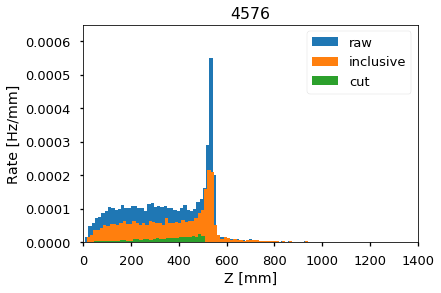

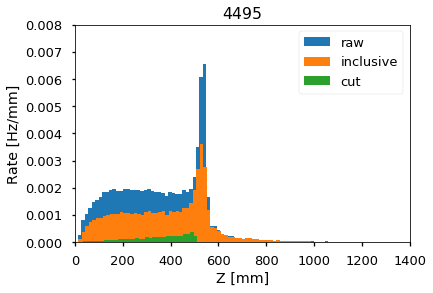

In [36]:
#### HISTOGRAMA Z DEL RUN 4576 CON/SIN CORTES

x,bins,p = pyplot.hist(Z_evt_4576, 100, alpha=1, label='raw');
bin_size_4576 = bins[2]-bins[1]
for item in p:
    item.set_height(item.get_height()/tiempo_total_4576/bin_size_4576)
#plt.ylim(0.0,0.009)
plt.ylim(0.0,0.00065)
plt.xlim(0.0,1400)
#plt.show()
x_inc,bins_inc,p_inc = pyplot.hist(Z_evt_4576[E_evt_4576>600], 100, alpha=1, label='inclusive')
bin_size_inc_4576_z = bins_inc[2]-bins_inc[1]
for item in p_inc:
    item.set_height(item.get_height()/tiempo_total_4576/bin_size_inc_4576_z)
x_sel,bins_sel,p_sel = pyplot.hist(data_sel_4576.Zavg, 34, alpha=1, label='cut')
bin_size_sel_4576_z = bins_sel[2]-bins_sel[1]
for item in p_sel:
    item.set_height(item.get_height()/tiempo_total_4576/bin_size_sel_4576_z)

pyplot.legend(loc='upper right')
plt.xlabel('Z [mm]')
plt.ylabel('Rate [Hz/mm]')
plt.title('4576')
pyplot.show()

plt.figure()

x_4495,bins_4495,p_4495 = pyplot.hist(Z_evt_4495, 100, alpha=1, label='raw');
bin_size_4495_z = bins_4495[2]-bins_4495[1]
for item in p_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_size_4495_z)
plt.ylim(0.0,0.12)
plt.ylim(0.0,0.008)
plt.xlim(0.0,1400)
#plt.show()
x_inc_4495,bins_inc_4495,p_inc_4495 = pyplot.hist(Z_evt_4495[E_evt_4495>600], 100, alpha=1, label='inclusive')
bin_size_inc_4495_z = bins_inc_4495[2]-bins_inc_4495[1]
for item in p_inc_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_size_inc_4495_z)
x_sel_4495,bins_sel_4495,p_sel_4495 = pyplot.hist(data_sel_4495.Zavg, 33, alpha=1, label='cut')
bin_size_sel_4495_z = bins_sel_4495[2]-bins_sel_4495[1]
for item in p_sel_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_size_sel_4495_z)

pyplot.legend(loc='upper right')
plt.xlabel('Z [mm]')
plt.ylabel('Rate [Hz/mm]')
plt.title('4495')
pyplot.show()


#print(bins_4495[2]-bins_4495[1])
#print(bins_inc_4495[2]-bins_inc_4495[1])
#print(bins_sel_4495[2]-bins_sel_4495[1])

## Histograma Z: 4495/4576

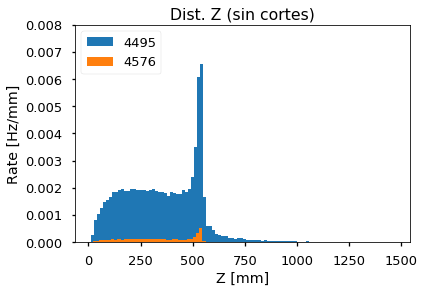

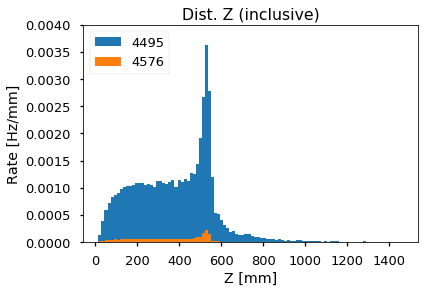

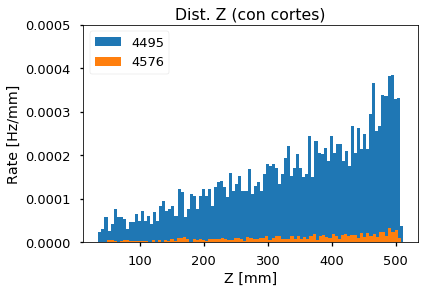

In [39]:
#### HISTOGRAMA Z COMPARACIÓN 4495/4576 ---> SIN CORTES
'''
z,bins,p_z_4495 = pyplot.hist(data_4495.Zavg, 100, alpha=1, label='4495');
#for item in p_z_4495:
    #item.set_height(item.get_height()/tiempo_total_4495)
#plt.ylim(0.0,0.01)
z,bins_sel,p_z_4576 = pyplot.hist(data_4576.Zavg, 100, alpha=1, label='4576');
#for item in p_z_4576:
    #item.set_height(item.get_height()/tiempo_total_4576)
pyplot.legend(loc='upper right')
plt.xlabel('Z [mm]')
plt.ylabel('Entries')
plt.title('Dist. Z')
pyplot.show()
'''
plt.figure()
z,bins_4495,p_z_4495 = pyplot.hist(Z_evt_4495, 100, alpha=1, label='4495');
bin_size_4495 = bins_4495[2]-bins_4495[1]
for item in p_z_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_size_4495)
plt.ylim(0.0,0.008)
#plt.ylim(0.0,0.125)
z,bins_4576,p_z_4576 = pyplot.hist(Z_evt_4576, 94, alpha=1, label='4576');
bin_size_4576 = bins_4576[2]-bins_4576[1]
for item in p_z_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_size_4576)
pyplot.legend(loc='upper left')
plt.xlabel('Z [mm]')
plt.ylabel('Rate [Hz/mm]')
plt.title('Dist. Z (sin cortes)')
pyplot.show()
#print('4495: ', bins_4495)
#print('4576: ', bins_4576)


plt.figure()
z_inc_4495,bins_inc_4495,p_z_inc_4495 = pyplot.hist(Z_evt_4495[E_evt_4495>600], 100, alpha=1, label='4495');
bin_inc_size_4495 = bins_inc_4495[2]-bins_inc_4495[1]
for item in p_z_inc_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_inc_size_4495)
#plt.ylim(0.0,0.06)
plt.ylim(0.0,0.004)
z_inc_4576,bins_inc_4576,p_z_inc_4576 = pyplot.hist(Z_evt_4576[E_evt_4576>600], 94, alpha=1, label='4576');
bin_inc_size_4576 = bins_inc_4576[2]-bins_inc_4576[1]
for item in p_z_inc_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_inc_size_4576)
pyplot.legend(loc='upper left')
plt.xlabel('Z [mm]')
plt.ylabel('Rate [Hz/mm]')
plt.title('Dist. Z (inclusive)')
pyplot.show()

plt.figure()
z_sel_4495,bins_sel_4495,p_z_sel_4495 = pyplot.hist(data_sel_4495.Zavg, 100, alpha=1, label='4495');
bin_sel_size_4495 = bins_sel_4495[2]-bins_sel_4495[1]
for item in p_z_sel_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_sel_size_4495)
#plt.ylim(0.0,0.002)
plt.ylim(0.0,0.0005)
#plt.xlim(0.0,1500)
z_sel_4576,bins_sel_4576,p_z_sel_4576 = pyplot.hist(data_sel_4576.Zavg, 94, alpha=1, label='4576');
bin_sel_size_4576 = bins_sel_4576[2]-bins_sel_4576[1]
for item in p_z_sel_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_sel_size_4576)
pyplot.legend(loc='upper left')
plt.xlabel('Z [mm]')
plt.ylabel('Rate [Hz/mm]')
plt.title('Dist. Z (con cortes)')
pyplot.show()


## Histograma Energía: 4495/4576

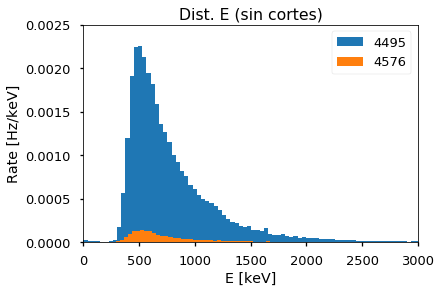

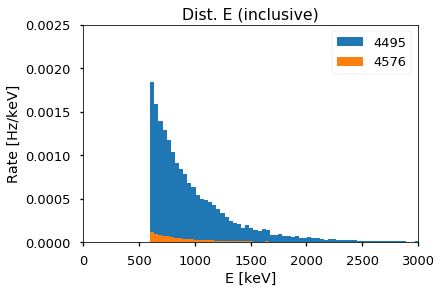

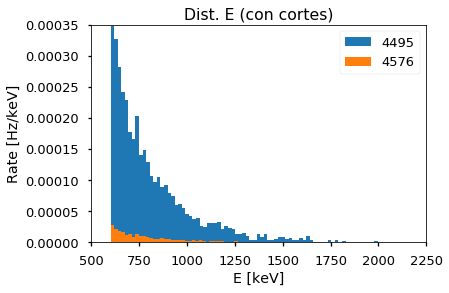

In [72]:
#### HISTOGRAMA E COMPARACIÓN 4495/4576 ---> SIN CORTES

e,bins_e_4495,p_e_4495 = pyplot.hist(E_evt_4495, 1000, alpha=1, label='4495');
bin_e_size_4495 = bins_e_4495[2]-bins_e_4495[1]
for item in p_e_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_e_size_4495)
#plt.ylim(0.0,0.10)
plt.ylim(0.0,0.0025)
#plt.ylim(0.0,0.02)
plt.xlim(0.0,3000)
e,bins_e_4576,p_e_4576 = pyplot.hist(E_evt_4576, 817, alpha=1, label='4576');
bin_e_size_4576 = bins_e_4576[2]-bins_e_4576[1]
for item in p_e_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_e_size_4576)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Rate [Hz/keV]')
plt.title('Dist. E (sin cortes)')
pyplot.show()


plt.figure()
e,bins_e_inc_4495,p_e_inc_4495 = pyplot.hist(E_evt_4495[E_evt_4495>600], 1000, alpha=1, label='4495');
bin_e_inc_size_4495 = bins_e_inc_4495[2]-bins_e_inc_4495[1]
for item in p_e_inc_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_e_inc_size_4495)
#plt.ylim(0.0,0.10)
plt.ylim(0.0,0.0025)
plt.xlim(0.0,3000)
e,bins_e_inc_4576,p_e_inc_4576 = pyplot.hist(E_evt_4576[E_evt_4576>600], 817, alpha=1, label='4576');
bin_e_inc_size_4576 = bins_e_inc_4576[2]-bins_e_inc_4576[1]
for item in p_e_inc_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_e_inc_size_4576)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
#plt.yscale('log')
plt.ylabel('Rate [Hz/keV]')
plt.title('Dist. E (inclusive)')
pyplot.show()


plt.figure()
e,bins_e_sel_4495,p_e_sel_4495 = pyplot.hist(data_sel_4495.energy, 100, alpha=1, label='4495');
bin_e_sel_size_4495 = bins_e_sel_4495[2]-bins_e_sel_4495[1]
for item in p_e_sel_4495:
    item.set_height(item.get_height()/tiempo_total_4495/bin_e_sel_size_4495)
#plt.ylim(0.0,0.007)
plt.ylim(0.0,0.00037)
e,bins_e_sel_4576,p_e_sel_4576 = pyplot.hist(data_sel_4576.energy, 99, alpha=1, label='4576');
bin_e_sel_size_4576 = bins_e_sel_4576[2]-bins_e_sel_4576[1]
for item in p_e_sel_4576:
    item.set_height(item.get_height()/tiempo_total_4576/bin_e_sel_size_4576)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Rate [Hz/keV]')
plt.title('Dist. E (con cortes)')
plt.axis([500, 1750, 0, 0.00035])
xticks(np.arange(500, 2500, step=250))

pyplot.show()

#print(bins_e_sel_4495[2]-bins_e_sel_4495[1])
#print(bins_e_sel_4576[2]-bins_e_sel_4576[1])

## Histograma Energía 4576 con/sin cortes

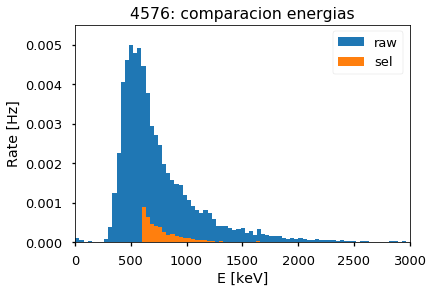

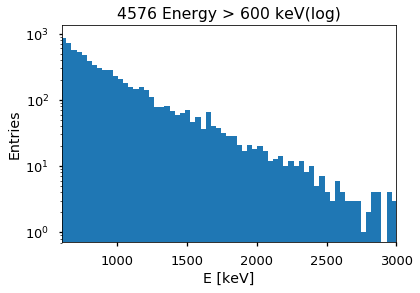

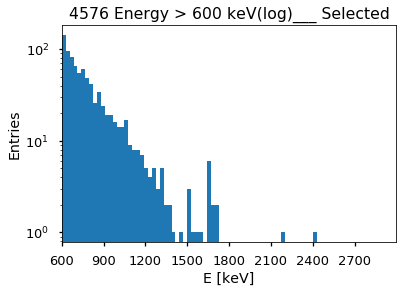

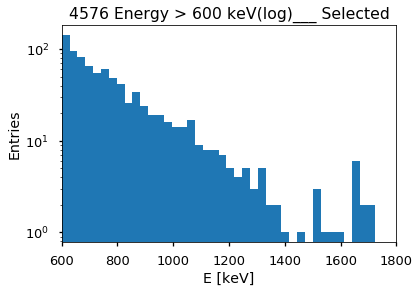

In [75]:
#### HISTOGRAMA ENERGIA DEL RUN 4576 CON/SIN CORTES
e_4576,bins,p_e_4576 = pyplot.hist(E_evt_4576, 800, alpha=1, label='raw');
for item in p_e_4576:
    item.set_height(item.get_height()/tiempo_total_4576)
#plt.ylim(0.0,0.01)
e_4576_sel,bins_sel,p_e_4576_sel = pyplot.hist(data_sel_4576.energy, 50, alpha=1, label='sel')
for item in p_e_4576_sel:
    item.set_height(item.get_height()/tiempo_total_4576)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Rate [Hz]')
plt.title('4576: comparacion energias')
plt.ylim(0.0,0.0055)
plt.xlim(xmin = 0.0, xmax = 3000)
pyplot.show()
'''
plt.figure()
e_4576,bins,p_e_4576 = pyplot.hist(data_4576.energy, 600, alpha=1, label='raw');
for item in p_e_4576:
    item.set_height(item.get_height()/tiempo_total_4576)
#plt.ylim(0.0,0.01)
e_4576_sel,bins_sel,p_e_4576_sel = pyplot.hist(data_sel.Zavg, 100, alpha=1, label='sel')
for item in p_e_4576_sel:
    item.set_height(item.get_height()/tiempo_total_4576)
pyplot.legend(loc='upper right')
plt.xlabel('E [keV]')
plt.ylabel('Rate [Hz]')
plt.title('4576: comparacion energias')
plt.ylim(0.0,0.01)
plt.yscale('log')
plt.xlim(xmin = 0.0, xmax = 5000)
pyplot.show()
plt.figure()
'''
plt.figure()
e_4576,bins,p_e_4576 = pyplot.hist(E_evt_4576, 800, alpha=1, label='raw');
plt.xlim(xmin = 600.0, xmax = 3000)
plt.yscale('log')
plt.xlabel('E [keV]')
plt.ylabel('Entries')
plt.title('4576 Energy > 600 keV(log)')
pyplot.show()

plt.figure()
pyplot.hist(data_sel_4576.energy, 65, alpha=1, label='raw');
plt.yscale('log')
plt.xlim(xmin = 600.0, xmax = 3000)
xticks(np.arange(600, 3000, step=300))
plt.xlabel('E [keV]')
plt.ylabel('Entries')
plt.title('4576 Energy > 600 keV(log)___ Selected')

plt.figure()
pyplot.hist(data_sel_4576.energy, 65, alpha=1, label='raw');
plt.yscale('log')
plt.xlim(xmin = 600.0, xmax = 1800)
#xticks(np.arange(600, 3000, step=300))
plt.xlabel('E [keV]')
plt.ylabel('Entries')
plt.title('4576 Energy > 600 keV(log)___ Selected')

## Histogramas (x,y)

### 4495

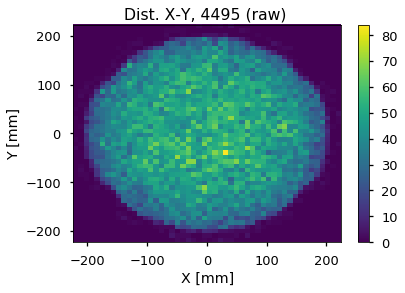

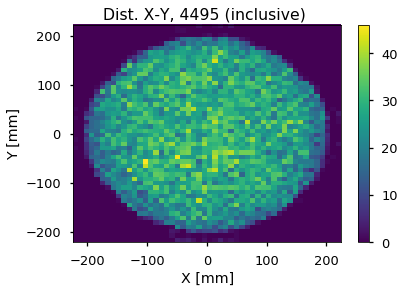

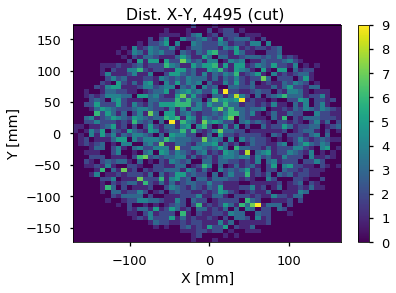

In [50]:
plt.figure()
hsti.hist2d(X_evt_4495, Y_evt_4495, 50);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4495 (raw) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(X_evt_4495[E_evt_4495>600], Y_evt_4495[E_evt_4495>600], 50);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4495 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4495.Xavg, data_sel_4495.Yavg, 50);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4495 (cut) ")
#plt.xlim(0,100)

### 4576

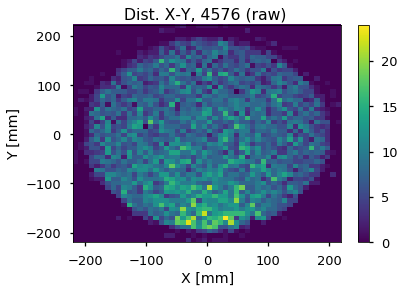

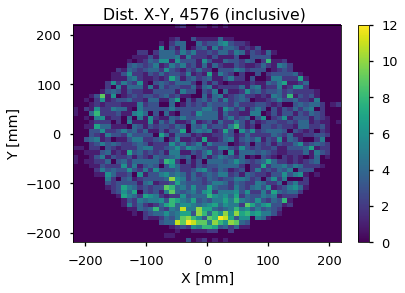

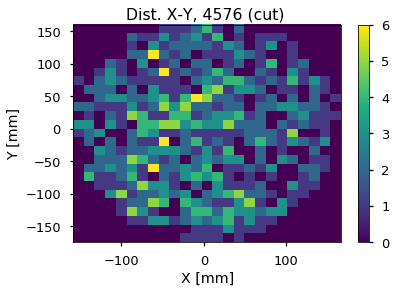

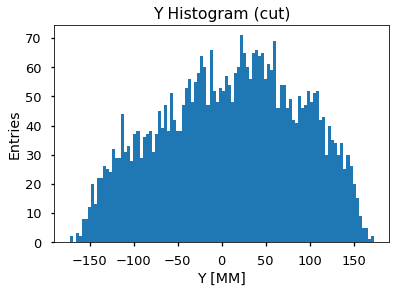

In [53]:
plt.figure()
hsti.hist2d(X_evt_4576, Y_evt_4576, 50);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4576 (raw) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(X_evt_4576[(E_evt_4576>600) & (maxZ_evt_4576<500)], Y_evt_4576[(E_evt_4576>600) & (maxZ_evt_4576<500)], 50);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4576 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4576.Xavg, data_sel_4576.Yavg, 25);
plt.colorbar()
hsti.labels("X [mm]", "Y [mm]", title = "Dist. X-Y, 4576 (cut) ")
#plt.xlim(0,100)

plt.figure()
pyplot.hist(data_sel_4495.Yavg, 100, alpha=1, label='4495');
plt.xlabel('Y [MM]')
plt.ylabel('Entries')
plt.title('Y Histogram (cut)')

## Histogramas (Y,Z)

### 4495

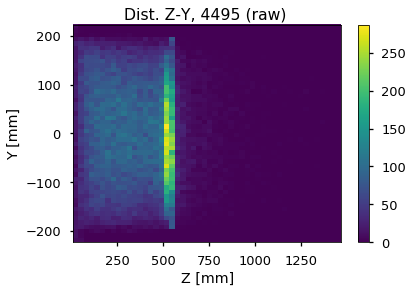

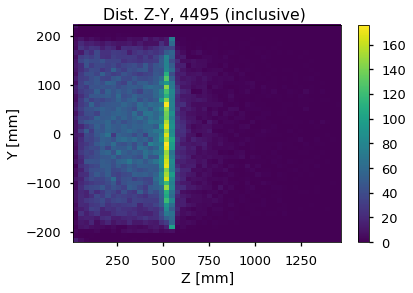

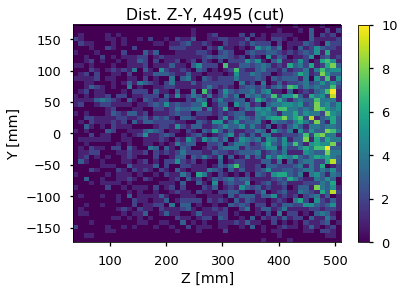

In [54]:
plt.figure()
hsti.hist2d(Z_evt_4495, Y_evt_4495, 50);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4495 (raw) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(Z_evt_4495[E_evt_4495>600], Y_evt_4495[E_evt_4495>600], 50);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4495 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4495.Zavg, data_sel_4495.Yavg, 50);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4495 (cut) ")
#plt.xlim(0,100)

### 4576

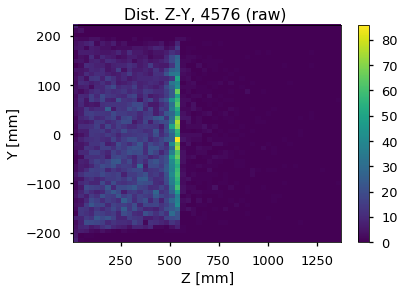

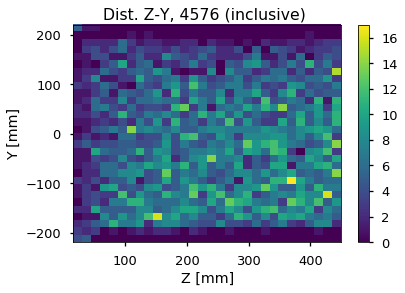

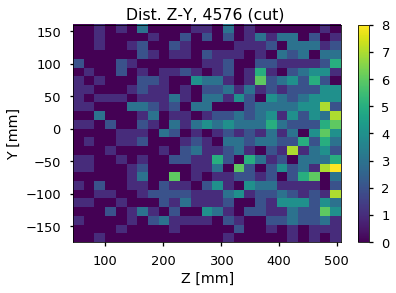

In [61]:
plt.figure()
hsti.hist2d(Z_evt_4576, Y_evt_4576, 50);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4576 (raw) ")

plt.figure()
#hsti.hist2d(data_4576[(data_4576.energy>600)].Zavg, data_4576[(data_4576.energy>600)].Yavg, 50);
hsti.hist2d(Z_evt_4576[(E_evt_4576>600) & (Z_evt_4576<450)], Y_evt_4576[(E_evt_4576>600) & (Z_evt_4576<450)], 30);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4576 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4576.Zavg, data_sel_4576.Yavg, 25);
plt.colorbar()
hsti.labels("Z [mm]", "Y [mm]", title = "Dist. Z-Y, 4576 (cut) ")
#plt.xlim(0,100)

## Distribución (Z,X)

### 4495

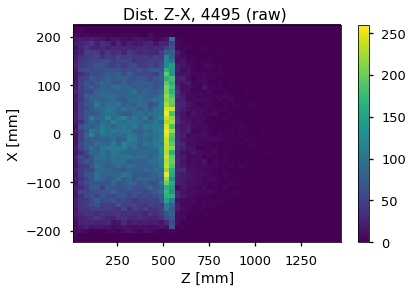

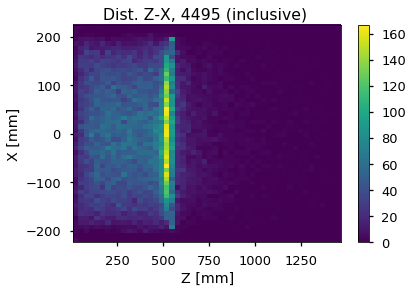

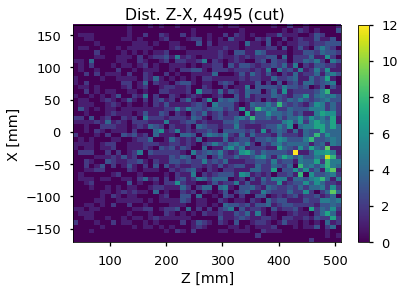

In [56]:
plt.figure()
hsti.hist2d(Z_evt_4495, X_evt_4495, 50);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4495 (raw) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(Z_evt_4495[E_evt_4495>600], X_evt_4495[E_evt_4495>600], 50);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4495 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4495.Zavg, data_sel_4495.Xavg, 50);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4495 (cut) ")
#plt.xlim(0,100)

### 4576

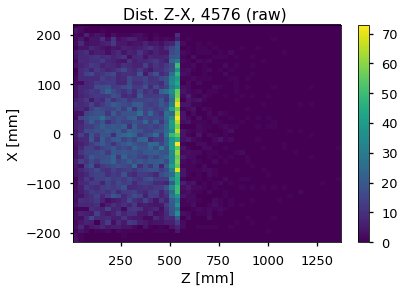

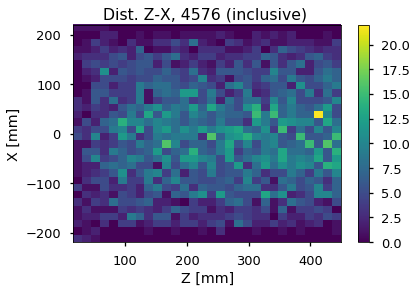

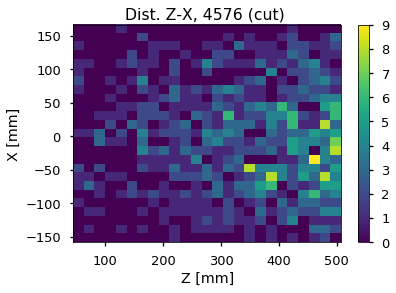

In [60]:
plt.figure()
hsti.hist2d(Z_evt_4576, X_evt_4576, 50);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4576 (raw) ")
#plt.xlim(0,100)

plt.figure()
#hsti.hist2d(data_4576[data_4576.energy>600].Zavg, data_4576[data_4576.energy>600].Xavg, 50);
hsti.hist2d(Z_evt_4576[(E_evt_4576>600) & (Z_evt_4576<450)], X_evt_4576[(E_evt_4576>600) & (Z_evt_4576<450)], 30);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4576 (inclusive) ")
#plt.xlim(0,100)

plt.figure()
hsti.hist2d(data_sel_4576.Zavg, data_sel_4576.Xavg, 25);
plt.colorbar()
hsti.labels("Z [mm]", "X [mm]", title = "Dist. Z-X, 4576 (cut) ")
#plt.xlim(0,100)